In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

In [2]:
data = pd.read_csv('./data/IBOV.csv')

# Análise da Correlação dos dados

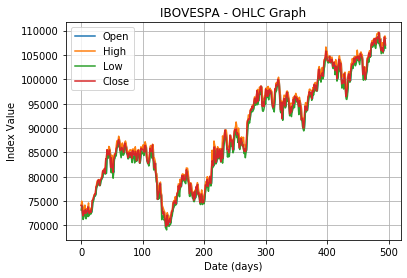

In [3]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(data['Date'])), data['Open'].values, label='Open')
ax.plot(np.arange(len(data['Date'])), data['High'].values, label='High')
ax.plot(np.arange(len(data['Date'])), data['Low'].values, label='Low')
ax.plot(np.arange(len(data['Date'])), data['Close'].values, label='Close')
ax.set(xlabel='Date (days)', ylabel='Index Value',
       title='IBOVESPA - OHLC Graph')
ax.legend()
ax.grid()

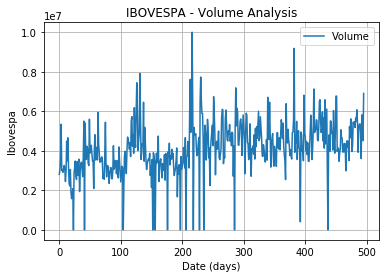

In [4]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(data['Date'])), data['Volume'].values, label='Volume')
ax.set(xlabel='Date (days)', ylabel='Ibovespa',
       title='IBOVESPA - Volume Analysis')
ax.legend()
ax.grid()

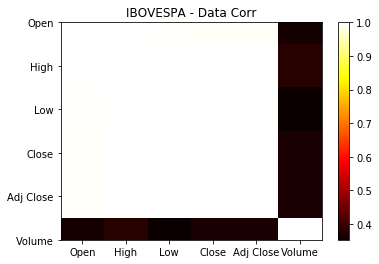

In [5]:
corr = data.corr()  
plt.imshow(corr, cmap='hot', interpolation='none')  
plt.colorbar()  
plt.xticks(range(len(corr)), corr.columns)  
plt.yticks(range(len(corr)), corr.columns)
plt.title('IBOVESPA - Data Corr')
plt.savefig("correl.png")  
plt.show()

# Processamento dos Dados (ARIMA - IBOVESPA [Close])

In [6]:
df = pd.read_csv('./data/IBOV.csv', header=0, index_col=0)
df = df['Close']
data = pd.Series(df.values,
                index = pd.DatetimeIndex(
                    data = (tuple(pd.date_range('27/11/2017',
                                                periods = 496,
                                                freq = 'B'))),
                    freq = 'B'
                ))

## Teste para validar se a função é estacionária
##### p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
##### p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

### Para d= 0

In [7]:
import pandas as pd
print("Results of Dickey-Fuller Test:")
df_test = adfuller(data, autolag = "AIC")
df_output = pd.Series(df_test[0:4],
                     index = ["Test Statistic", "p-value", "Number of Lags",
                             "Number of Observations Used"])
print(df_output)

Results of Dickey-Fuller Test:
Test Statistic                  -0.981747
p-value                          0.759863
Number of Lags                   2.000000
Number of Observations Used    493.000000
dtype: float64


### Para d= 1

In [8]:
import pandas as pd
data_diff1 = data.diff().dropna()
print("Results of Dickey-Fuller Test:")
df_test = adfuller(data_diff1, autolag = "AIC")
df_output = pd.Series(df_test[0:4],
                     index = ["Test Statistic", "p-value", "Number of Lags",
                             "Number of Observations Used"])
print(df_output)

Results of Dickey-Fuller Test:
Test Statistic                -1.736166e+01
p-value                        5.199467e-30
Number of Lags                 1.000000e+00
Number of Observations Used    4.930000e+02
dtype: float64


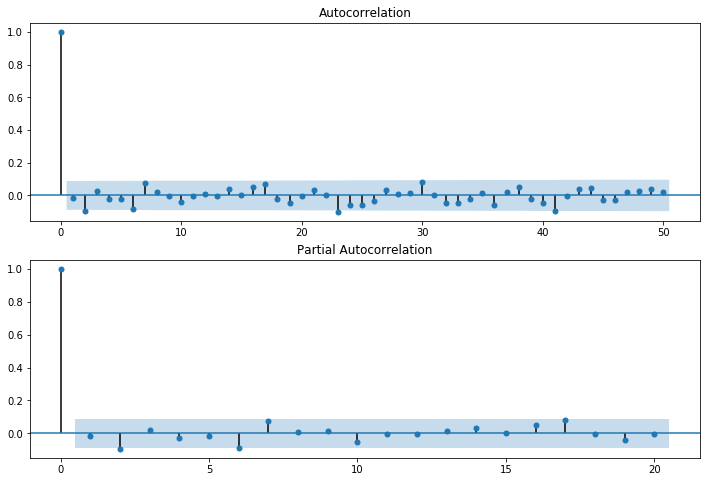

In [9]:
# Autocorrelation (MA - q)
# Partial Autocorrelation (AR - p)
#TODO: Perguntar se deve ser feito os calculos com o diff1
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(data_diff1, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(data_diff1, lags=20, ax=ax2)

##### Analisando o gráfico de Autocorrelation temos q=0 e p=0

### Validação do ARIMA para (0,1,0) - Método Analítico

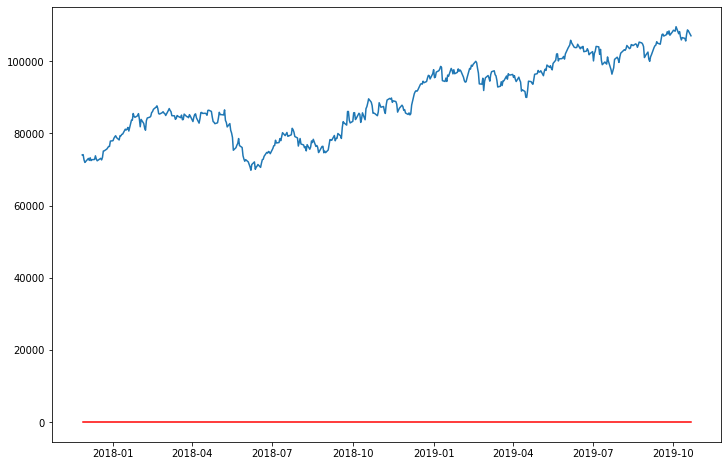

In [51]:
# ARIMA model setup
# --> Considerações do residuo do ARIMA
# --> Mean (meadia)
# --> Autocorrelation (Autocorrelação)
# --> Normal distribution (Distribuição Normal)
model = ARIMA(data, order=(0, 1, 0))
results_ar1 = model.fit()
plt.figure(figsize=(12,8))
plt.plot(data)
plt.plot(results_ar1.fittedvalues, color='red')

ARIMA [Mean]:  -1.6995608063433506e-14


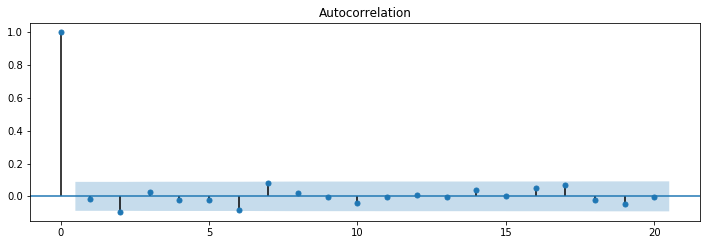

In [52]:
# Mean
print('ARIMA [Mean]: ', np.mean(results_ar1.resid))

# ACF plot to test for autorrelation
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(results_ar1.resid, lags=20, ax=ax1)

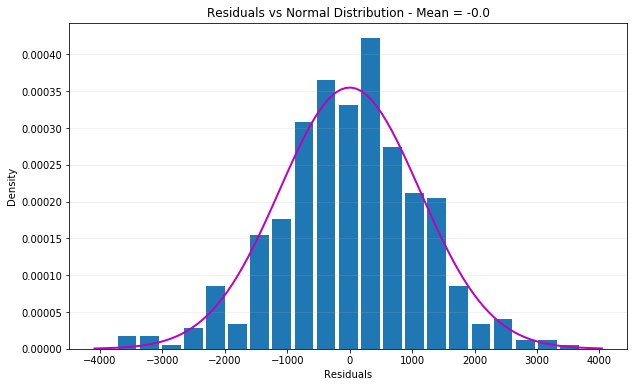

In [53]:
import matplotlib.pyplot as plt
from numpy import linspace
from scipy.stats import norm

plt.figure(figsize=(10,6))
plt.hist(results_ar1.resid, bins='auto', density=True, rwidth=0.85, label='residuals')
mean_resid, std_resid = norm.fit(results_ar1.resid)
xmin, xmax = plt.xlim()
curve_length = linspace(xmin, xmax, 100)
bell_curve = norm.pdf(curve_length, mean_resid, std_resid)
plt.plot(curve_length, bell_curve, 'm', linewidth=2)
plt.grid(axis='y', alpha=0.2)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residuals vs Normal Distribution - Mean = '+str(round(mean_resid, 2)))
plt.show()

In [54]:
#Informações relevantes são:
#    AIC (Akaike): (Estudar)
#    BIC: Base info criterion (Estudar)
results_ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  495
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -4179.406
Method:                           css   S.D. of innovations           1123.615
Date:                Sun, 01 Dec 2019   AIC                           8362.812
Time:                        14:41:57   BIC                           8371.222
Sample:                    11-28-2017   HQIC                          8366.114
                         - 10-21-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         66.6667     50.503      1.320      0.187     -32.317     165.650
==============================================================================
"""

### ARIMA Iterativo - Método Computacional (Sem considerar sazonalidade)

In [57]:
arima_model = pm.auto_arima(data, error_action='ignore', suppress_warnings=True,
                    seasonal=False, start_q=0, start_p=0,
                    max_order=50, max_d=3, stepwise=False, trace=True)

Fit ARIMA: order=(0, 1, 0); AIC=8362.812, BIC=8371.222, Fit time=0.026 seconds
Fit ARIMA: order=(0, 1, 1); AIC=8364.624, BIC=8377.238, Fit time=0.048 seconds
Fit ARIMA: order=(0, 1, 2); AIC=8361.977, BIC=8378.795, Fit time=0.113 seconds
Fit ARIMA: order=(0, 1, 3); AIC=8363.672, BIC=8384.695, Fit time=0.415 seconds
Fit ARIMA: order=(0, 1, 4); AIC=8364.858, BIC=8390.085, Fit time=0.731 seconds
Fit ARIMA: order=(0, 1, 5); AIC=8366.827, BIC=8396.259, Fit time=0.922 seconds
Fit ARIMA: order=(1, 1, 0); AIC=8364.660, BIC=8377.273, Fit time=0.046 seconds
Fit ARIMA: order=(1, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 0); AIC=8362.205, BIC=8379.023, Fit time=0.242 seconds
Fit ARIMA: order=(2, 1, 1); AIC=8

In [58]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  495
Model:                 ARIMA(4, 1, 4)   Log Likelihood               -4170.484
Method:                       css-mle   S.D. of innovations           1102.921
Date:                Sun, 01 Dec 2019   AIC                           8360.969
Time:                        14:46:23   BIC                           8403.014
Sample:                             1   HQIC                          8377.474
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         67.1142     42.677      1.573      0.116     -16.532     150.760
ar.L1.D.y      0.1911      0.250      0.763      0.446      -0.300       0.682
ar.L2.D.y     -0.3800      0.186     -2.043      0.042      -0.745      -0.015
ar.L3.D.y     -0.2273      0.206     -1.104      0.270      -0.631       0.176
ar.L4.D.y      0.5132      0.213      2.407      0.016       0.095       0.931
ma.L1.D.y     -0.2152      0.235     -0.914      0.361      -0.677       0.246
ma.L2.D.y      0.2943      0.169      1.745      0.082      -0.036       0.625
ma.L3.D.y      0.3067      0.183      1.680      0.094      -0.051       0.665
ma.L4.D.y     -0.6093      0.203     -2.994      0.003      -1.008      -0.211
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2830           -0.0000j            1.2830           -0.5000
AR.2            0.1450           -1.0181j            1.0284           -0.2275
AR.3            0.1450           +1.0181j            1.0284            0.2275
AR.4            1.4361           -0.0000j            1.4361           -0.0000
MA.1           -1.1750           -0.0000j            1.1750           -0.5000
MA.2            0.1674           -1.0057j            1.0195           -0.2238
MA.3            0.1674           +1.0057j            1.0195            0.2238
MA.4            1.3437           -0.0000j            1.3437           -0.0000
-----------------------------------------------------------------------------
"""

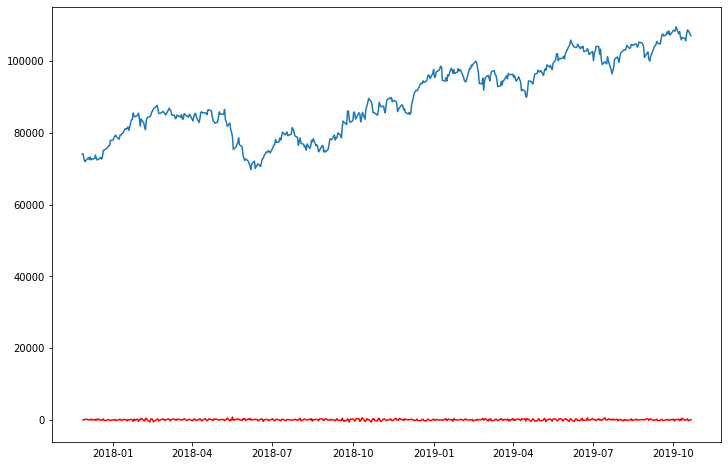

In [63]:
# ARIMA model setup
# --> Considerações do residuo do ARIMA
# --> Mean (meadia)
# --> Autocorrelation (Autocorrelação)
# --> Normal distribution (Distribuição Normal)
model = ARIMA(data, order=(4, 1, 4))
results_ar1 = model.fit()
plt.figure(figsize=(12,8))
plt.plot(data)
plt.plot(results_ar1.fittedvalues, color='red')

ARIMA [Mean]:  -0.24113477603374958


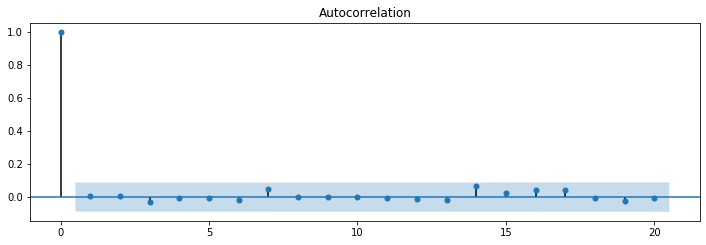

In [64]:
# Mean
print('ARIMA [Mean]: ', np.mean(results_ar1.resid))

# ACF plot to test for autorrelation
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(results_ar1.resid, lags=20, ax=ax1)

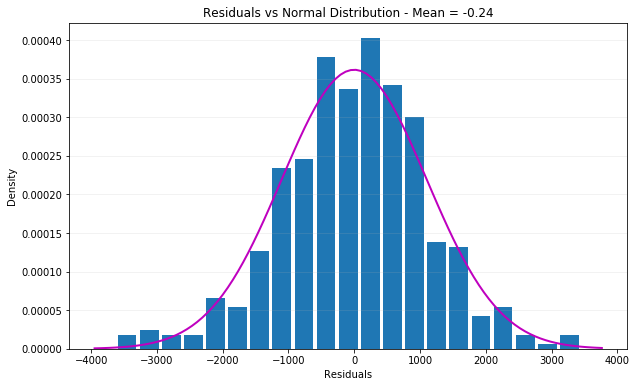

In [65]:
import matplotlib.pyplot as plt
from numpy import linspace
from scipy.stats import norm

plt.figure(figsize=(10,6))
plt.hist(results_ar1.resid, bins='auto', density=True, rwidth=0.85, label='residuals')
mean_resid, std_resid = norm.fit(results_ar1.resid)
xmin, xmax = plt.xlim()
curve_length = linspace(xmin, xmax, 100)
bell_curve = norm.pdf(curve_length, mean_resid, std_resid)
plt.plot(curve_length, bell_curve, 'm', linewidth=2)
plt.grid(axis='y', alpha=0.2)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residuals vs Normal Distribution - Mean = '+str(round(mean_resid, 2)))
plt.show()

### ARIMA Iterativo - Método Computacional (Sazonalidade semanal)

In [60]:
arima_model = pm.auto_arima(data, error_action='ignore', suppress_warnings=True,
                    seasonal=True, m=5, start_q=0, start_p=0, start_Q=0, start_P=0, max_D=3,
                    max_order=10, max_d=3, stepwise=False, trace=True)

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 5); AIC=8362.812, BIC=8371.222, Fit time=0.116 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 1, 5); AIC=8364.687, BIC=8377.301, Fit time=0.200 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 2, 5); AIC=8366.448, BIC=8383.266, Fit time=0.397 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 0, 5); AIC=8364.691, BIC=8377.304, Fit time=0.195 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 5); AIC=8366.650, BIC=8383.469, Fit time=0.358 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 2, 5); AIC=8368.435, BIC=8389.458, Fit time=2.394 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 0, 5); AIC=8366.450, BIC=8383.269, Fit time=0.385 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 1, 5); AIC=8368.435, BIC=8389.458, Fit time=0.995 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 2, 5); AIC=8370.437, BIC=8395.664, Fit time=1.241 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_o

Fit ARIMA: order=(1, 1, 3) seasonal_order=(1, 0, 2, 5); AIC=8369.787, BIC=8407.628, Fit time=4.600 seconds
Fit ARIMA: order=(1, 1, 3) seasonal_order=(2, 0, 0, 5); AIC=8368.162, BIC=8401.799, Fit time=2.323 seconds
Fit ARIMA: order=(1, 1, 3) seasonal_order=(2, 0, 1, 5); AIC=8369.787, BIC=8407.628, Fit time=5.125 seconds
Fit ARIMA: order=(1, 1, 3) seasonal_order=(2, 0, 2, 5); AIC=8371.791, BIC=8413.837, Fit time=5.818 seconds
Fit ARIMA: order=(1, 1, 4) seasonal_order=(0, 0, 0, 5); AIC=8365.107, BIC=8394.539, Fit time=1.448 seconds
Fit ARIMA: order=(1, 1, 4) seasonal_order=(0, 0, 1, 5); AIC=8369.434, BIC=8403.071, Fit time=1.351 seconds
Fit ARIMA: order=(1, 1, 4) seasonal_order=(0, 0, 2, 5); AIC=8371.173, BIC=8409.014, Fit time=1.652 seconds
Fit ARIMA: order=(1, 1, 4) seasonal_order=(1, 0, 0, 5); AIC=8369.435, BIC=8403.072, Fit time=0.760 seconds
Fit ARIMA: order=(1, 1, 4) seasonal_order=(1, 0, 1, 5); AIC=8371.418, BIC=8409.259, Fit time=3.234 seconds
Fit ARIMA: order=(1, 1, 4) seasonal_o

Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 0, 1, 5); AIC=8367.147, BIC=8400.783, Fit time=3.129 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 0, 2, 5); AIC=8369.075, BIC=8406.916, Fit time=3.520 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(1, 0, 0, 5); AIC=8367.147, BIC=8400.783, Fit time=3.718 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(1, 0, 1, 5); AIC=8369.146, BIC=8406.987, Fit time=5.094 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(1, 0, 2, 5); AIC=8371.340, BIC=8413.386, Fit time=5.165 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(2, 0, 0, 5); AIC=8369.071, BIC=8406.912, Fit time=4.435 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(2, 0, 1, 5); AIC=8371.058, BIC=8413.104, Fit time=7.765 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(2, 0, 2, 5); AIC=8372.817, BIC=8419.067, Fit time=8.875 seconds
Fit ARIMA: order=(3, 1, 3) seasonal_order=(0, 0, 0, 5); AIC=8367.144, BIC=8400.780, Fit time=2.620 seconds
Fit ARIMA: order=(3, 1, 3) seasonal_o

In [61]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  496
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -4176.866
Date:                Sun, 01 Dec 2019   AIC                           8361.733
Time:                        15:03:31   BIC                           8378.551
Sample:                             0   HQIC                          8368.335
                                - 496                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     79.9603     48.282      1.656      0.098     -14.670     174.590
ma.L1         -0.0062      0.043     -0.142      0.887      -0.091       0.079
ma.L2         -0.0530      0.032     -1.638      0.101      -0.117       0.010
sigma2       1.26e+06   7.09e+04     17.778      0.000    1.12e+06     1.4e+06
===================================================================================
Ljung-Box (Q):                       38.01   Jarque-Bera (JB):                11.19
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                            -0.19
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

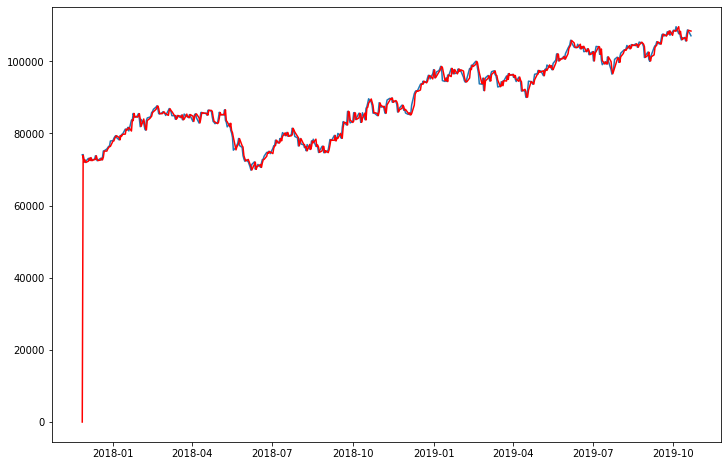

In [67]:
# ARIMA model setup
# --> Considerações do residuo do ARIMA
# --> Mean (meadia)
# --> Autocorrelation (Autocorrelação)
# --> Normal distribution (Distribuição Normal)
model = SARIMAX(data, order=(0, 1, 2))
results_ar1 = model.fit()
plt.figure(figsize=(12,8))
plt.plot(data)
plt.plot(results_ar1.fittedvalues, color='red')

SARIMAX [Mean]:  224.40397771800406


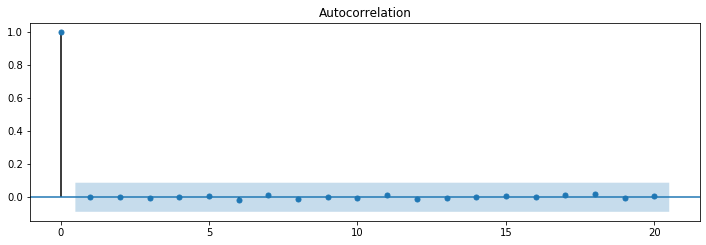

In [68]:
# Mean
print('SARIMAX [Mean]: ', np.mean(results_ar1.resid))

# ACF plot to test for autorrelation
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(results_ar1.resid, lags=20, ax=ax1)

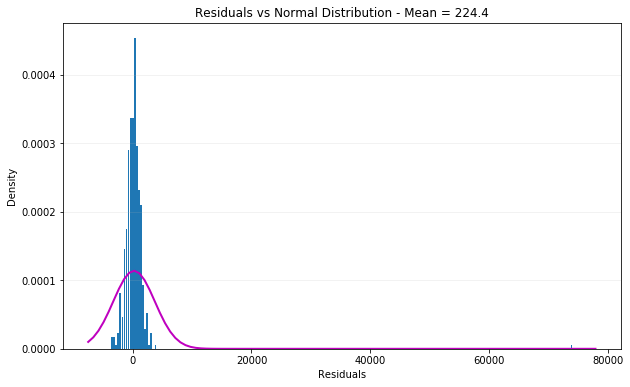

In [69]:
import matplotlib.pyplot as plt
from numpy import linspace
from scipy.stats import norm

plt.figure(figsize=(10,6))
plt.hist(results_ar1.resid, bins='auto', density=True, rwidth=0.85, label='residuals')
mean_resid, std_resid = norm.fit(results_ar1.resid)
xmin, xmax = plt.xlim()
curve_length = linspace(xmin, xmax, 100)
bell_curve = norm.pdf(curve_length, mean_resid, std_resid)
plt.plot(curve_length, bell_curve, 'm', linewidth=2)
plt.grid(axis='y', alpha=0.2)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residuals vs Normal Distribution - Mean = '+str(round(mean_resid, 2)))
plt.show()

In [70]:
#Informações relevantes são:
#    AIC (Akaike): (Estudar)
#    BIC: Base info criterion (Estudar)
results_ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  496
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -4177.986
Date:                Sun, 01 Dec 2019   AIC                           8361.973
Time:                        16:32:23   BIC                           8374.587
Sample:                    11-27-2017   HQIC                          8366.925
                         - 10-21-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0031      0.044     -0.071      0.943      -0.089       0.083
ma.L2         -0.0500      0.033     -1.498      0.134      -0.115       0.015
sigma2      1.267e+06   7.16e+04     17.693      0.000    1.13e+06    1.41e+06
===================================================================================
Ljung-Box (Q):                       38.14   Jarque-Bera (JB):                11.07
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                            -0.19
Prob(H) (two-sided):                  0.32   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""